# Estimer une probabilité de dépassement de seuil - Application au cas de la poutre en flexion


## Définition du modèle

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import math
import tabulate

In [2]:
distributionE = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
distributionE.setDescription(["E"])
parametersF = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
distributionF = ot.ParametrizedDistribution(parametersF)
distributionF.setDescription(["F"])
distributionL = ot.Uniform(2.50, 2.60)  # En mètres
distributionL.setDescription(["L"])
distributionI = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # En m⁴
distributionI.setDescription(["I"])

X = ot.JointDistribution([distributionE, distributionF, distributionL, distributionI])

In [3]:
g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (m)"])

Enfin, nous définissons le vecteur aléatoire de sortie.

In [4]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (m)"])

La cellule suivante définit le seuil qui mène à l'évènement redouté.

In [5]:
seuilStandard = 0.21

## Par Monte-Carlo simple avec un budget fixé

La manière la plus simple de faire une telle étude consiste à fixer le nombre de simulations à l'avance. En d'autres termes, on fixe $n$ et on génère un échantillon de la variable de sortie $Y$ de taille $n$. C'est la méthode « classique ».

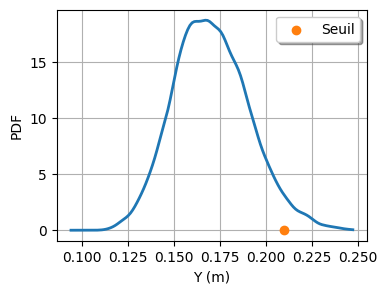

In [6]:
sampleSize = 10000
ySample = Y.getSample(sampleSize)  # ⚠️ Peut être long
# Trace une estimation de la densité de probabilité
graph = ot.KernelSmoothing().build(ySample).drawPDF()
graph.setLegends([""])
cloud = ot.Cloud([seuilStandard], [0.0])
cloud.setPointStyle("o")
cloud.setLegend("Seuil")
graph.add(cloud)
graph.setXTitle("Y (m)")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La probabilité recherchée peut être calculée en évaluant la fonction de répartition complémentaire de l'échantillon.

In [7]:
pfHat = ySample.computeEmpiricalCDF([seuilStandard], True)
pfHat

0.0357

La fonction suivante permet de calculer l'écart-type de la distribution gaussienne asymptotique de l'estimateur de la probabilité de dépassement.

In [8]:
def computePfStandardDeviation(pfHat, n):
    """
    Calcule l'écart-type de l'estimateur de la probabilité de défaillance.

    Cette fonction évalue l'écart-type de l'estimateur de Monte-Carlo
    pour une probabilité, en utilisant la formule de l'écart-type d'une
    proportion empirique.

    Parameters
    ----------
    pfHat : float
        L'estimation de la probabilité de défaillance.
    n : int
        La taille de l'échantillon.

    Returns
    -------
    sigmaPf : float
        L'écart-type de l'estimateur.
    """

    sigmaPf = math.sqrt(pfHat * (1 - pfHat) / n)
    return sigmaPf

La fonction suivante calcule la distribution asymptotique de l'estimateur ainsi qu'un intervalle de confiance de la probabilité de dépassement de seuil.

In [9]:
def computeConfidenceInterval(pfHat, n, confidenceLevel=0.95):
    """
    Calcule l'intervalle de confiance asymptotique d'une probabilité.

    Cette fonction construit un intervalle de confiance bilatéral pour une
    probabilité estimée par simulation de Monte-Carlo, en utilisant
    l'approximation normale (intervalle de Wald).

    Parameters
    ----------
    pfHat : float
        L'estimation de la probabilité de défaillance.
    n : int
        La taille de l'échantillon utilisé pour l'estimation.
    confidenceLevel : float, optional
        Le niveau de confiance (probabilité de couverture) de l'intervalle.
        La valeur par défaut est 0.95.

    Returns
    -------
    pfDistribution : ot.Normal
        La distribution asymptotique de l'estimateur (loi Normale).
    lowerBound : float
        La borne inférieure de l'intervalle de confiance.
    upperBound : float
        La borne supérieure de l'intervalle de confiance.
    """
    sigmaPf = computePfStandardDeviation(pfHat, n)
    pfDistribution = ot.Normal(pfHat, sigmaPf)
    bounds = pfDistribution.computeBilateralConfidenceInterval(confidenceLevel)
    lowerBound = bounds.getLowerBound()[0]
    upperBound = bounds.getUpperBound()[0]
    return pfDistribution, lowerBound, upperBound

La cellule suivante calcule l'intervalle de confiance à 95% de la probabilité.

In [10]:
confidenceLevel = 0.95
pfDistribution, lowerBound, upperBound = computeConfidenceInterval(
    pfHat, sampleSize, confidenceLevel
)
print(
    f"Intervalle de confiance à {(confidenceLevel) * 100:.2f}% = "
    f"[{lowerBound:f},{upperBound:f}]"
)

Intervalle de confiance à 95.00% = [0.032063,0.039337]


La cellule suivante calcule la distribution de l'estimateur.

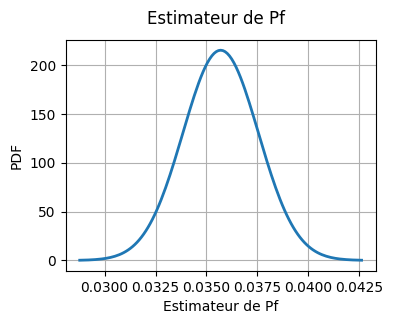

In [11]:
graph = pfDistribution.drawPDF()
graph.setXTitle("Estimateur de Pf")
graph.setTitle("Estimateur de Pf")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Par Monte-Carlo avec un algorithme itératif

La classe `ProbabilitySimulationAlgorithm` permet de calculer une probabilité avec une précision fixée par l'utilisateur en utilisant la taille d'échantillon $n$ la plus petite possible. C'est la méthode « moderne ».

In [12]:
myEvent = ot.ThresholdEvent(Y, ot.Greater(), seuilStandard)
blockSize = 1000
experiment = ot.MonteCarloExperiment()
myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgo.setMaximumOuterSampling(10000)
myAlgo.setBlockSize(blockSize)
myAlgo.setMaximumCoefficientOfVariation(0.01)
myAlgo.run()  # ⚠️ Peut être long
result = myAlgo.getResult()
outerSampling = result.getOuterSampling()
print(f"outerSampling = {outerSampling}")
functionCalls = blockSize * outerSampling
print(f"functionCalls = {functionCalls}")
pfHat = result.getProbabilityEstimate()
print(f"pfHat = {pfHat}")

outerSampling = 276
functionCalls = 276000
pfHat = 0.03501086956521739


In [13]:
confidenceLevel = 0.95  # Le niveau de confiance de l'intervalle
pfHatDistribution = result.getProbabilityDistribution()
pfHatInterval = pfHatDistribution.computeBilateralConfidenceInterval(confidenceLevel)
lowerBoundIterative = pfHatInterval.getLowerBound()[0]
upperBoundIterative = pfHatInterval.getUpperBound()[0]
print(
    f"{confidenceLevel * 100:.2f}% confidence interval = "
    f"[{lowerBoundIterative:f}, {upperBoundIterative:f}]"
)


95.00% confidence interval = [0.034325, 0.035697]


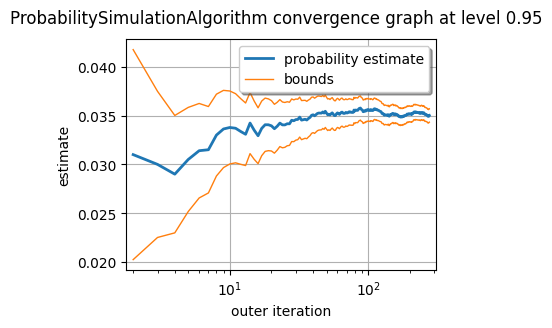

In [14]:
graph = myAlgo.drawProbabilityConvergence()
graph.setLogScale(ot.GraphImplementation.LOGX)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Solution de l'exercice 1 : sensibilité aux paramètres

In [15]:
def computeFailureProbability(
    threshold,
    coefficientOfVariation,
    blockSize=1000,
    maximumOuterSampling=10000,
    confidenceLevel=0.95,
    verbose=False
):
    """
    Calcule la probabilité de défaillance par simulation de Monte-Carlo.

    Cette fonction configure et exécute un algorithme de simulation de
    probabilité pour estimer la probabilité que la variable aléatoire
    globale `Y` dépasse un seuil donné. Elle utilise un critère d'arrêt
    basé sur le coefficient de variation cible ou le nombre maximum
    d'itérations.

    Parameters
    ----------
    threshold : float
        Le seuil de dépassement pour l'événement considéré (Y > seuil).
    coefficientOfVariation : float
        Le coefficient de variation cible pour l'arrêt de l'algorithme.
    blockSize : int, optional
        La taille du bloc pour l'expérience de Monte-Carlo. La valeur par
        défaut est 1000.
    maximumOuterSampling : int, optional
        Le nombre maximum d'itérations externes. La valeur par défaut est
        10000.
    confidenceLevel : float, optional
        Le niveau de confiance pour le calcul de l'intervalle.
        La valeur par défaut est 0.95.
    verbose : bool, optional
        Si True, affiche les détails de la simulation (seuil, CV, résultats)
        sur la sortie standard. La valeur par défaut est False.

    Returns
    -------
    threshold : float
        Le seuil utilisé pour la simulation.
    coefficientOfVariation : float
        Le coefficient de variation cible.
    pfHat : float
        L'estimation de la probabilité de défaillance.
    confidenceInterval : list of float
        L'intervalle de confiance bilatéral [borne_inf, borne_sup] correspondant
        au niveau de confiance spécifié.
    functionCalls : int
        Le nombre total d'appels à la fonction limite d'état.
    """
    if verbose:
        print(f"Seuil = {threshold:f}, C.V. = {coefficientOfVariation:f}")
    myEvent = ot.ThresholdEvent(Y, ot.Greater(), threshold)
    experiment = ot.MonteCarloExperiment()
    myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
    myAlgo.setMaximumOuterSampling(maximumOuterSampling)
    myAlgo.setBlockSize(blockSize)
    myAlgo.setMaximumCoefficientOfVariation(coefficientOfVariation)
    myAlgo.run()
    result = myAlgo.getResult()
    pfHat = result.getProbabilityEstimate()
    pfConfidenceLength = result.getConfidenceLength(confidenceLevel)
    outerSampling = result.getOuterSampling()
    functionCalls = blockSize * outerSampling
    confidenceInterval = [
        pfHat - pfConfidenceLength / 2.0,
        pfHat + pfConfidenceLength / 2.0,
    ]
    if verbose:
        print(
            f"    outerSampling = {outerSampling}, "
            f"Nombre d'appels à G = {functionCalls}",
            flush=True,
        )
        print(f"    Pf estimée = {pfHat:f}", flush=True)
        print(
            f"    Intervalle de confiance à {confidenceLevel * 100:.2f}% = "
            f"[{confidenceInterval[0]:f},{confidenceInterval[1]:f}]",
            flush=True,
        )
    return threshold, coefficientOfVariation, pfHat, confidenceInterval, functionCalls

In [16]:
simulationSeuilBas = computeFailureProbability(seuilStandard * 0.9, 0.01, verbose=True)
simulationSeuilNormal = computeFailureProbability(seuilStandard, 0.01, verbose=True)
simulationSeuilHaut = computeFailureProbability(seuilStandard * 1.1, 0.01, verbose=True)

Seuil = 0.189000, C.V. = 0.010000
    outerSampling = 46, Nombre d'appels à G = 46000


    Pf estimée = 0.179804
    Intervalle de confiance à 95.00% = [0.176293,0.183315]
Seuil = 0.210000, C.V. = 0.010000
    outerSampling = 273, Nombre d'appels à G = 273000
    Pf estimée = 0.035407
    Intervalle de confiance à 95.00% = [0.034713,0.036100]
Seuil = 0.231000, C.V. = 0.010000
    outerSampling = 2359, Nombre d'appels à G = 2359000
    Pf estimée = 0.004226
    Intervalle de confiance à 95.00% = [0.004143,0.004309]


In [17]:
data = []
for simulation in [simulationSeuilBas, simulationSeuilNormal, simulationSeuilHaut]:
    threshold, coefficientOfVariation, pfHat, confidenceInterval, functionCalls = (
        simulation
    )
    data.append(
        [
            threshold,
            coefficientOfVariation,
            f"{pfHat:.6f}",
            f"[{confidenceInterval[0]:.6f}, {confidenceInterval[1]:.6f}]",
            functionCalls,
        ]
    )

tabulate.tabulate(
    data,
    tablefmt="html",
    headers=["Seuil (m)", "CV", "PfHat", f"Intervalle de confiance {confidenceLevel}", "Nombre appels à g"],
)

Seuil (m),CV,PfHat,Intervalle de confiance 0.95,Nombre appels à g
0.189,0.01,0.179804,"[0.176293, 0.183315]",46000
0.21,0.01,0.035407,"[0.034713, 0.036100]",273000
0.231,0.01,0.004226,"[0.004143, 0.004309]",2359000


La table précédente présente les résultats que l'on obtient avec CV=0.01 et différentes valeurs du seuil $s$. 



On observe que, lorsque le seuil augmente, 
- la probabilité diminue, 
- le nombre d'appels à la fonction $g$ augmente.

Le fait que la probabilité diminue lorsque le seuil augmente est cohérent avec la queue droite de la distribution de la déviation $Y$, avec de rares grandes déviations. 

Le fait que le nombre d'appels à $g$ augmente lorsque le seuil augmente est une conséquence de l'algorithme utilisé par `ProbabilitySimulationAlgorithm`, dans lequel nous avons fixé le coefficient de variation à 0.01. Ainsi, puisque la probabilité est de plus en plus proche de zéro, l'algorithme est contraint d'augmenter la taille de l'échantillon pour atteindre le coefficient de variation imposé.

In [18]:
simulationCVBas = computeFailureProbability(seuilStandard, 0.1, verbose=True)
simulationCVNormal = computeFailureProbability(seuilStandard, 0.05, verbose=True)
simulationCVHaut = computeFailureProbability(seuilStandard, 0.01, verbose=True)

Seuil = 0.210000, C.V. = 0.100000
    outerSampling = 4, Nombre d'appels à G = 4000
    Pf estimée = 0.029250
    Intervalle de confiance à 95.00% = [0.024025,0.034475]
Seuil = 0.210000, C.V. = 0.050000
    outerSampling = 12, Nombre d'appels à G = 12000
    Pf estimée = 0.032667
    Intervalle de confiance à 95.00% = [0.029485,0.035849]
Seuil = 0.210000, C.V. = 0.010000
    outerSampling = 277, Nombre d'appels à G = 277000
    Pf estimée = 0.034895
    Intervalle de confiance à 95.00% = [0.034212,0.035579]


In [19]:
data = []
for simulation in [simulationCVBas, simulationCVNormal, simulationCVHaut]:
    threshold, coefficientOfVariation, pfHat, confidenceInterval, functionCalls = (
        simulation
    )
    data.append(
        [
            threshold,
            coefficientOfVariation,
            f"{pfHat:.6f}",
            f"[{confidenceInterval[0]:.6f}, {confidenceInterval[1]:.6f}]",
            functionCalls,
        ]
    )

tabulate.tabulate(
    data,
    tablefmt="html",
    headers=["Seuil (m)", "CV", "PfHat", f"I.C. {confidenceLevel}", "Nb. appels à g"],
)

Seuil (m),CV,PfHat,I.C. 0.95,Nb. appels à g
0.21,0.1,0.02925,"[0.024025, 0.034475]",4000
0.21,0.05,0.032667,"[0.029485, 0.035849]",12000
0.21,0.01,0.034895,"[0.034212, 0.035579]",277000


La table précédente présente les résultats que l'on obtient avec différentes valeurs du coefficient de variation. 

On observe que, lorsque le coefficient de variation diminue, le nombre d'appels à $g$ augmente considérablement. On observe également que la largeur de l'intervalle de confiance diminue. 

Cela est cohérent avec le résultat que nous avons présenté et qui montre que le nombre d'appels à $g$ dépend de l'inverse du carré de CV. C'est la raison pour laquelle, même si $\textrm{CV}=0.01$ semble un minimum acceptable, on se contente souvent de $\textrm{CV}=0.1$.

## Solution de l'exercice 2 : probabilité en fonction du seuil

In [20]:
sampleSize = 100000
print(f"sampleSize = {sampleSize}")
ySample = Y.getSample(sampleSize)  # ⚠️ Un seul échantillon de sortie
confidenceLevel = 0.95
nbThresholds = 10
thresholdSample = ot.Sample.BuildFromPoint(
    np.linspace(seuilStandard * 0.8, seuilStandard * 1.3, nbThresholds)
)
pfSample = ot.Sample(nbThresholds, 1)
# boundsSample[:, 0] : borne inférieure
# boundsSample[:, 1] : borne supérieure
boundsSample = ot.Sample(nbThresholds, 2)
for i in range(nbThresholds):
    s = thresholdSample[i, 0]
    pfHat = ySample.computeEmpiricalCDF([s], True)
    pfSample[i, 0] = pfHat
    # Le code suivant est équivalent à l'appel à getConfidenceLength()
    _, lowerBound, upperBound = computeConfidenceInterval(
        pfHat, sampleSize, confidenceLevel
    )
    boundsSample[i] = [lowerBound, upperBound]
    sigmaPf = computePfStandardDeviation(pfHat, sampleSize)
    cv = sigmaPf / pfHat
    print(f"s={s:f}, pfHat={pfHat:f} in [{lowerBound:f},{upperBound:f}], C.V.={cv:f}")

sampleSize = 100000
s=0.168000, pfHat=0.531690 in [0.528597,0.534783], C.V.=0.002968
s=0.179667, pfHat=0.315200 in [0.312320,0.318080], C.V.=0.004661
s=0.191333, pfHat=0.156430 in [0.154179,0.158681], C.V.=0.007343
s=0.203000, pfHat=0.065250 in [0.063719,0.066781], C.V.=0.011969
s=0.214667, pfHat=0.022980 in [0.022051,0.023909], C.V.=0.020619
s=0.226333, pfHat=0.006500 in [0.006002,0.006998], C.V.=0.039096
s=0.238000, pfHat=0.001880 in [0.001612,0.002148], C.V.=0.072864
s=0.249667, pfHat=0.000430 in [0.000302,0.000558], C.V.=0.152466
s=0.261333, pfHat=0.000140 in [0.000067,0.000213], C.V.=0.267243
s=0.273000, pfHat=0.000010 in [-0.000010,0.000030], C.V.=0.999995


In [21]:
def convertColorToAlpha(color, alphaChannel=128):
    """
    Convertit une couleur pleine en une couleur avec transparence (alpha).

    Parameters
    ----------
    color : str
        La couleur au format Hexadécimal.
    alpha : int
        Le canal alpha (opacité) de l'espace colorimétrique [R, V, B, A] (0-255).

    Returns
    -------
    alpha_color : str
        La couleur au format Hexadécimal avec transparence.
    """
    [r, g, b] = ot.Drawable.ConvertToRGB(color)
    alpha_color = ot.Drawable.ConvertFromRGBA(r, g, b, alphaChannel)
    return alpha_color

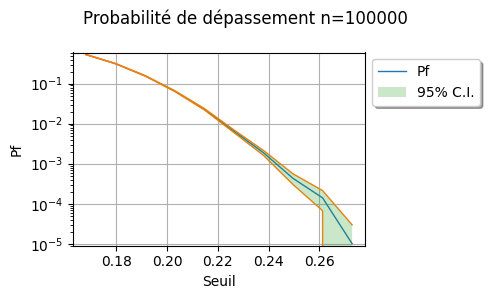

In [22]:
myGraph = ot.Graph(f"Probabilité de dépassement n={sampleSize}", "Seuil", "Pf", True, "topright")
colors = ot.Drawable.BuildDefaultPalette(3)
myPfCurve = ot.Curve(thresholdSample, pfSample, "Pf")
myPfCurve.setColor(colors[0])
myLBCurve = ot.Curve(thresholdSample, boundsSample[:, 0], "")
myLBCurve.setColor(colors[1])
myUBCurve = ot.Curve(thresholdSample, boundsSample[:, 1], "")
myUBCurve.setColor(colors[1])
myGraph.add(myPfCurve)
myGraph.add(myLBCurve)
myGraph.add(myUBCurve)
polygon = ot.Polygon.FillBetween(
    thresholdSample, boundsSample[:, 0], boundsSample[:, 1]
)
fillColor = convertColorToAlpha(colors[2], 64)
polygon.setColor(fillColor)
polygon.setLegend("95% C.I.")
myGraph.add(polygon)
myGraph.setLogScale(ot.GraphImplementation.LOGY)
myGraph.setLegendCorner((1.0, 1.0))
myGraph.setLegendPosition("upper left")
view = otv.View(myGraph, figure_kw={"figsize": (5.0, 3.0)})

On observe que, lorsque le seuil $s$ augmente, alors la probabilité $p_f$ diminue. Cela montre que l'évènement recherché est de plus en plus rare. C'est physiquement cohérent, puisque les grandes déviations verticales sont moins fréquentes. C'est cohérent avec la distribution des déviations verticales, qui sont moins fréquentes lorsque la déviation augmente. 

On observe que le coefficient de variation augmente lorsque la probabilité se rapproche de zéro. Cela est cohérent avec le calcul théorique qui indique que $\operatorname{CV}(p_f) \approx \sqrt{\frac{1}{p_f n}}$ quand $p_f\approx 0$.

## Calcul de la probabilité de référence

Dans cette section, nous estimons la probabilité de référence avec un échantillon Monte-Carlo de taille relativement grande.

In [23]:
myEvent = ot.ThresholdEvent(Y, ot.Greater(), seuilStandard)
blockSize = 100000
experiment = ot.MonteCarloExperiment()
myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgo.setMaximumOuterSampling(100000)
myAlgo.setBlockSize(blockSize)
myAlgo.setMaximumCoefficientOfVariation(0.005)
myAlgo.run()  # ⚠️ Peut être long
result = myAlgo.getResult()

outerSampling = result.getOuterSampling()
functionCalls = blockSize * outerSampling
print(f"functionCalls = {functionCalls}")
pfHat = result.getProbabilityEstimate()
print(f"pfHat = {pfHat:.6f}")
confidenceLevel = 0.95
pfDistribution, lowerBound, upperBound = computeConfidenceInterval(
    pfHat, functionCalls, confidenceLevel
)
print(
    f"Intervalle de confiance à {(confidenceLevel) * 100:.2f}% = "
    f"[{lowerBound:f},{upperBound:f}]"
)

functionCalls = 1200000
pfHat = 0.034686
Intervalle de confiance à 95.00% = [0.034358,0.035013]
